# Financial US Stocks data reports classification 
    
   
# Marcos Barragán & Adrián González 
    
# Machine Learning
    
### Final Practice
    
### 15/01/2021
    
__CUNEF__

# Dividend payments classifications:

In [25]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pickle
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import scikitplot as skplt
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [26]:
data_train = pd.read_excel('../data/data_train.xlsx', index_col=0)
data_test = pd.read_excel('../data/data_test.xlsx', index_col=0)

We have to drop `Class` and `price_var`, because they are the other variables we are taking as target.

Furthermore, it is important to drop out `PRICE_VAR[%]`, `Class`, `Dividend per Share` and `Dividend payments Company vs. Sector` variables, because `div_vs_sector` comes out from them (transformed into categorical).

In [28]:
data_train = data_train.drop(['price_var',
                              'Class',
                              'Dividend per Share',
                              'Dividend Payments Company vs. Sector [%]'],
                               axis=1)

data_test = data_test.drop(['price_var',
                            'Class',
                            'Dividend per Share',
                            'Dividend Payments Company vs. Sector [%]'], 
                             axis=1)

In [29]:
data_train['Div_vs_sector'] = data_train['Div_vs_sector'].astype('object')

data_test['Div_vs_sector'] = data_test['Div_vs_sector'].astype('object')

### Including Pipelines to process our data:

Pipeline will be used to scale our variables but, moreover, it will be used as well to remove NA values applying K-Nearest Neighbours techniques. We will consider euclidean method and weights based on their distance to the 20 nearest neighbours.

In [30]:
numeric_transformer = Pipeline(steps=[
                                      ('imputer', 
                                       KNNImputer(n_neighbors=20, 
                                                  weights='distance', 
                                                  metric='nan_euclidean', 
                                                  copy=True)),
    
                                      ('scaler', 
                                       StandardScaler())
                                        
                                      ])

In [31]:
numeric_features = data_train.select_dtypes(include=['int64', 'float64','int32']).columns

In [32]:
preprocessor1 = ColumnTransformer(
                                  transformers=[
                                      ('num', numeric_transformer, numeric_features)
                                  ])

In [33]:
pl2 = '../pipelines/pipeline_div.sav'

pickle.dump(preprocessor1, open(pl2, 'wb'))

### Train and test definition:

We need to reconsider y train and test as numeric feature once the Pipeline has been applied.

In [34]:
xtrain = data_train.drop('Div_vs_sector', axis=1)

ytrain = data_train['Div_vs_sector']
ytrain = ytrain.astype('int64')

In [35]:
xtest = data_test.drop('Div_vs_sector', axis=1)

ytest = data_test['Div_vs_sector']
ytest = ytest.astype('int64')

## Gaussian Naive-Bayes Models:

Gaussian NB is codified in Python as GaussianNB(). 

First of all, we need to load our pipeline and apply it to data:

In [36]:
pl2 = '../pipelines/pipeline_div.sav'
tratamiento = pickle.load(open(pl2, 'rb'))

In [37]:
gnb = Pipeline(steps=[
                       ('preprocesado', tratamiento),
                       ('clasificador', GaussianNB())])

gnb.fit(xtrain, ytrain).predict(xtest)

array([2, 2, 2, ..., 1, 0, 1])

+ ### GNB Scores:

In [38]:
gnb.score(xtrain, ytrain)

0.551524995488179

In [39]:
gnb.score(xtest, ytest)

0.5749077490774908

+ ### GNB Predictions and Probabilities:

In [40]:
y_pred = gnb.predict(xtest)

In [41]:
y_prob = gnb.predict_proba(xtest)

+ ### ROC GNB model:

In [42]:
def roc(model, title):
    
    skplt.metrics.plot_roc(ytest, y_prob) # un roc con todas las metricas
    plt.title(f"ROCs curve for {title}.");

We see that the ROCs curves for our model are pretty good. The AUC we get back are:

+ 71% for class-0 classifiers,


+ 75% for class-1 classifiers,


+ 80% for class-2 classifiers.

This is great, because we achieve a really high AUC values for class-1 and class-2 companies classifier, and those are the values we are interested (remember 2 represents those companies that share out more dividends than the mean of its sector).

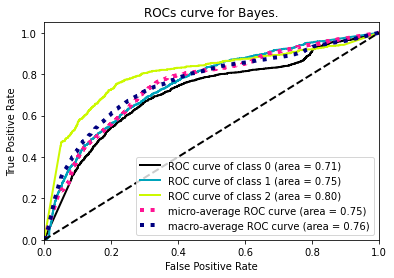

In [43]:
roc(gnb, 'Bayes')

+ ### Some classification reports:

In [44]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.47      0.58      2116
           1       0.52      0.70      0.60      1353
           2       0.42      0.66      0.51       596

    accuracy                           0.57      4065
   macro avg       0.57      0.61      0.56      4065
weighted avg       0.63      0.57      0.58      4065



+ ### Confusion Matrices:

The confusion matrix we are developing here shows out that 1 and 2 classes are really well classified: we hit 70% of times class 1 and 66% of times class 2. Moreover, class-2 missclassified values are more times classified as 1 than as 0 classes. 

Class-0 classification is not as good as the other ones, but this is not so bad because, as we have said before, we are more interested in class-1 and class-2 classification hits.

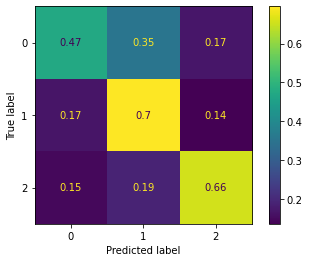

In [45]:
plot_confusion_matrix(gnb, xtest, y_true=ytest, normalize='true');

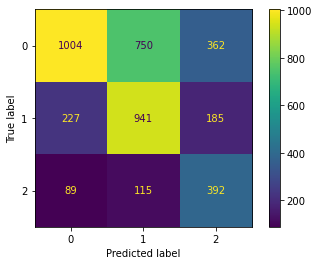

In [46]:
plot_confusion_matrix(gnb, X=xtest, y_true=ytest);

We would have liked to plot the cumulative curve to make better and more complete classification reports, but it is not possible to make those kind of graphs with 3-variables target.

+ ### ROC curve with optimal point:

If we plot out the ROC curve and explicitly highlight the best score for that curve, we will be obtaining the metric that appears in the accuracy part.

In [58]:
probabilidad_po = y_prob[:, 1]

In [59]:
falsos_po, verdaderos_po, intervalos = roc_curve(ytest, 
                                                 probabilidad_po, 
                                                 pos_label=1)

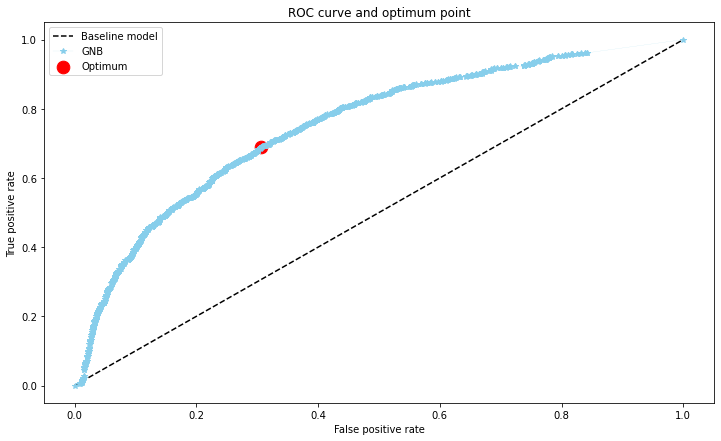

In [60]:
media = np.sqrt(verdaderos_po * (1-falsos_po))
maximo_g = np.argmax(media)

plt.figure(figsize=(12, 7))


plt.plot([0,1], [0,1], 
         linestyle='--', 
         color='black',
         label='Baseline model') 


plt.plot(falsos_po,
         verdaderos_po, 
         marker='*',
         linewidth=0.1,
         color='skyblue',
         label='GNB')


plt.scatter(falsos_po[maximo_g], 
            verdaderos_po[maximo_g], 
            s=160, 
            marker='o', 
            color='red', 
            label='Optimum')

 
plt.title('ROC curve and optimum point')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

The optimal point shows out that the best classification is when TPR (True Positive Rate) is 0.7 and FPR is about 0.3. 

## SVM

In order to get a comparision for NB model we have just developed, we will implement a SVM model and see the results it shows out:

In [61]:
%%time

svm_m = Pipeline(steps=[
                        ('preprocesado', tratamiento),
                        ('clasificador', SVC(random_state=1789,
                                             C=1.5,
                                             max_iter=2000,
                                             probability=True))])

svm_m.fit(xtrain, ytrain)

CPU times: user 1min 23s, sys: 13.8 s, total: 1min 37s
Wall time: 1min 40s


/Users/adrian_gr/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Pipeline(steps=[('preprocesado',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=20,
                                                                              weights='distance')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Revenue Growth', 'Cost of Revenue', 'EPS', 'Gross Margin',
       'EBITDA Margin', 'Free Cash Flow margin', 'Receivables', 'Inventories',
       'Total assets', 'Total current liabilities',
       'Total non-cu...
       'returnOnEquity', 'debtEquityRatio', 'freeCashFlowPerShare',
       'Net Income per Share', 'Net Debt to EBITDA', 'Current ratio', 'ROIC',
       'Enterprise Value over EBITDA', 'PRICE_VAR[%]',


+ ### SVM Scores:

SVM model gives out slightly better results for accuracy than the other NB model:

In [62]:
svm_m.score(xtrain, ytrain)

0.7014979245623534

In [63]:
svm_m.score(xtest, ytest)

0.6282902829028291

+ ### SVM Predictions and Probabilities:

In [64]:
y_pred = svm_m.predict(xtest)

In [65]:
y_prob = svm_m.predict_proba(xtest)

+ ### ROC SVM model:

In [66]:
def roc(model, title):
    
    skplt.metrics.plot_roc(ytest, y_prob) # un roc con todas las metricas
    plt.title(f"ROCs curve for {title}.");

We see that the ROCs curves for SVM are even better. The AUC we get back are:

+ 74% for class-0 classifiers,


+ 75% for class-1 classifiers,


+ 88% for class-2 classifiers.

This is great, because we achieve a really high AUC values for class-1 and class-2 companies classifier, even higher than NB model.

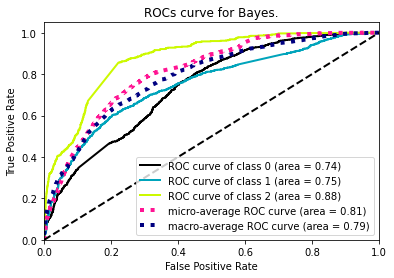

In [67]:
roc(svm_m, 'SVM')

+ ### Some classification reports:

Surprisingly, f1-score for class-2 is worse than what we obtained for NB model.

In [68]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      2116
           1       0.57      0.63      0.60      1353
           2       0.78      0.29      0.43       596

    accuracy                           0.63      4065
   macro avg       0.67      0.55      0.57      4065
weighted avg       0.64      0.63      0.62      4065



+ ### Confusion Matrices:

The confusion matrix we are developing here shows out that class 0 is really well classified, and acceptably for class-1. Class-2 classification is dreadful. We poorly obtain a 30% of hits for this one, and most of the times it missclassifies class-2 companies with class-0 ones.

If the aim of this model is to get dividends predictions, we should use NB model instead SVM.

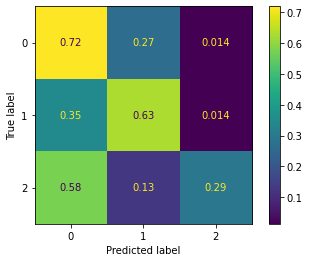

In [70]:
plot_confusion_matrix(svm_m, xtest, y_true=ytest, normalize='true');

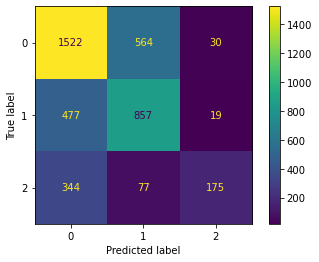

In [71]:
plot_confusion_matrix(svm_m, X=xtest, y_true=ytest);

+ ### ROC curve with optimal point:

If we plot out the ROC curve and explicitly highlight the best score for that ROC, we will be obtaining the metric that appears in the accuracy part.

In [72]:
probabilidad_po = y_prob[:, 1]

In [73]:
falsos_po, verdaderos_po, intervalos = roc_curve(ytest, 
                                                 probabilidad_po, 
                                                 pos_label=1)

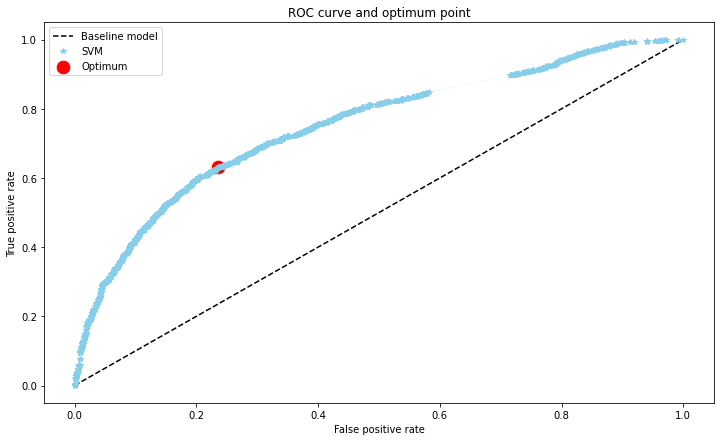

In [74]:
media = np.sqrt(verdaderos_po * (1-falsos_po))
maximo_g = np.argmax(media)

plt.figure(figsize=(12, 7))


plt.plot([0,1], [0,1], 
         linestyle='--', 
         color='black',
         label='Baseline model') 


plt.plot(falsos_po,
         verdaderos_po, 
         marker='*',
         linewidth=0.1,
         color='skyblue',
         label='SVM')


plt.scatter(falsos_po[maximo_g], 
            verdaderos_po[maximo_g], 
            s=160, 
            marker='o', 
            color='red', 
            label='Optimum')


plt.title('ROC curve and optimum point')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

The best accuracy we get from this model is a 65% of TPR over a 25% of NPR.

## Bibliography:

+ https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html


+ https://www.investopedia.com/terms/d/dividend.asp#:~:text=Key%20Takeaways-,A%20dividend%20is%20the%20distribution%20of%20some%20of%20a%20company's,their%20money%20into%20the%20venture.


+ https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826?gi=ff2283cc5d00